In [34]:
import os
import networkx as nx
import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from nestedness_calculator import NestednessCalculator
import csv


In [35]:
#!pip install cugraph
# import cugraph as cnx

In [36]:
path = "graphs/nodes_hashtag/"
MANIFESTACION = "nat"
MAXCOMP = False
    

In [37]:
if MAXCOMP:
    file_maxcomp = "_maxcomp"
else:
    file_maxcomp =''

In [38]:
def calc_nestedness(G):
    mat = nx.to_numpy_array(G, weight=None)
    mat = mat[~np.all(mat == 0, axis=1)]
    mat = mat[:,~np.all(mat == 0, axis=0)]
    nodf_score = NestednessCalculator(mat).nodf(mat)
    return nodf_score

In [39]:
dict_file = {}
with open("data/files/" + MANIFESTACION + file_maxcomp + ".csv", "r") as file:
   reader = csv.DictReader(file)
   for row in reader:
       dict_file[row["hour"]] = row

In [40]:
direct = path + MANIFESTACION + '/'
arr_clust = []
arr_hour = []
arr_mod = []
arr_nest = []
print(direct)
with open("data/files/" + MANIFESTACION + file_maxcomp + ".csv", "a") as file:
   writer = csv.DictWriter(file, fieldnames=["hour", "nestedness", "modularity", "clusterization"])
   for root, dirs, files in os.walk(direct, topdown=False):
      for name in tqdm(files):
         if name.endswith(".gexf"):
               hora = name[:-5]
               arr_hour.append(hora)
               print("Analizando grafo", hora)
               if not hora in dict_file.keys():
                  G = nx.read_gexf(direct + name)
                  nestedness = calc_nestedness(G)
                  arr_nest.append(nestedness)
                  avg_clust=nx.average_clustering(G)
                  arr_clust.append(avg_clust)
                  modularity_louv = nx.community.modularity(G, nx.community.louvain_communities(G, seed=123))
                  arr_mod.append(modularity_louv)
                  writer.writerow({'hour': hora, 'nestedness': nestedness, 'clusterization': avg_clust, 'modularity': modularity_louv})
               #print("Analizado grafo", name[:-5], "coef_avg_clust:", round(avg_clust, 6), "coef_mod:", round(modularity_louv, 6))
               else:
                  print(hora, "ya está guardado")
                  arr_nest.append(float(dict_file[hora]["nestedness"]))
                  arr_clust.append(float(dict_file[hora]["clusterization"]))
                  arr_mod.append(float(dict_file[hora]["modularity"]))


graphs/nodes_hashtag/nat/


100%|██████████| 260/260 [00:00<00:00, 24731.13it/s]

Analizando grafo 429578
429578 ya está guardado
Analizando grafo 429656
429656 ya está guardado
Analizando grafo 429713
429713 ya está guardado
Analizando grafo 429694
429694 ya está guardado
Analizando grafo 429730
429730 ya está guardado
Analizando grafo 429534
429534 ya está guardado
Analizando grafo 429635
429635 ya está guardado
Analizando grafo 429637
429637 ya está guardado
Analizando grafo 429613
429613 ya está guardado
Analizando grafo 429542
429542 ya está guardado
Analizando grafo 429771
429771 ya está guardado
Analizando grafo 429655
429655 ya está guardado
Analizando grafo 429758
429758 ya está guardado
Analizando grafo 429563
429563 ya está guardado
Analizando grafo 429737
429737 ya está guardado
Analizando grafo 429746
429746 ya está guardado
Analizando grafo 429536
429536 ya está guardado
Analizando grafo 429755
429755 ya está guardado
Analizando grafo 429732
429732 ya está guardado
Analizando grafo 429557
429557 ya está guardado
Analizando grafo 429599
429599 ya está g

In [41]:
data = list(zip(arr_hour, arr_clust, arr_mod, arr_nest))
data.sort()
hour_sort, clust_sort, mod_sort, nest_sort = zip(*data)
hour_sort = list(hour_sort)
clust_sort = list(clust_sort)
mod_sort = list(mod_sort)
nest_sort = list(nest_sort)

In [42]:
dt_sort_arr=[]
for hour in hour_sort:
    dt_sort_arr.append(datetime.datetime.fromtimestamp(int(hour)*3600))
print(MANIFESTACION, ", hora con avg_clust max", dt_sort_arr[clust_sort.index(max(clust_sort))], "hour_name:", hour_sort[clust_sort.index(max(clust_sort))])
print(MANIFESTACION, ", hora con avg_clust min", dt_sort_arr[clust_sort.index(min(clust_sort))], "hour_name:", hour_sort[clust_sort.index(min(clust_sort))])

print(MANIFESTACION, ", hora con modularity max", dt_sort_arr[mod_sort.index(max(mod_sort))], "hour_name:", hour_sort[mod_sort.index(max(mod_sort))])
print(MANIFESTACION, ", hora con modularity min", dt_sort_arr[mod_sort.index(min(mod_sort))], "hour_name:", hour_sort[mod_sort.index(min(mod_sort))])

print(MANIFESTACION, ", hora con nestedness max", dt_sort_arr[nest_sort.index(max(nest_sort))], "hour_name:", hour_sort[nest_sort.index(max(nest_sort))])
print(MANIFESTACION, ", hora con nestedness min", dt_sort_arr[nest_sort.index(min(nest_sort))], "hour_name:", hour_sort[nest_sort.index(min(nest_sort))])

nat , hora con avg_clust max 2019-01-08 22:00:00 hour_name: 429717
nat , hora con avg_clust min 2019-01-05 01:00:00 hour_name: 429624
nat , hora con modularity max 2019-01-02 09:00:00 hour_name: 429560
nat , hora con modularity min 2019-01-08 08:00:00 hour_name: 429703
nat , hora con nestedness max 2019-01-05 01:00:00 hour_name: 429624
nat , hora con nestedness min 2019-01-03 09:00:00 hour_name: 429584


['429531', '429532', '429533', '429534', '429535', '429536', '429537', '429538', '429539', '429540', '429541', '429542', '429543', '429544', '429545', '429546', '429547', '429548', '429549', '429550', '429551', '429552', '429553', '429554', '429555', '429556', '429557', '429558', '429559', '429560', '429561', '429562', '429563', '429564', '429565', '429566', '429567', '429568', '429569', '429570', '429571', '429572', '429573', '429574', '429575', '429576', '429577', '429578', '429579', '429580', '429581', '429582', '429583', '429584', '429585', '429586', '429587', '429588', '429589', '429590', '429591', '429592', '429593', '429594', '429595', '429596', '429597', '429598', '429599', '429600', '429601', '429602', '429603', '429604', '429605', '429606', '429607', '429608', '429609', '429610', '429611', '429612', '429613', '429614', '429615', '429616', '429617', '429618', '429619', '429620', '429621', '429622', '429623', '429624', '429625', '429626', '429627', '429628', '429629', '429630',

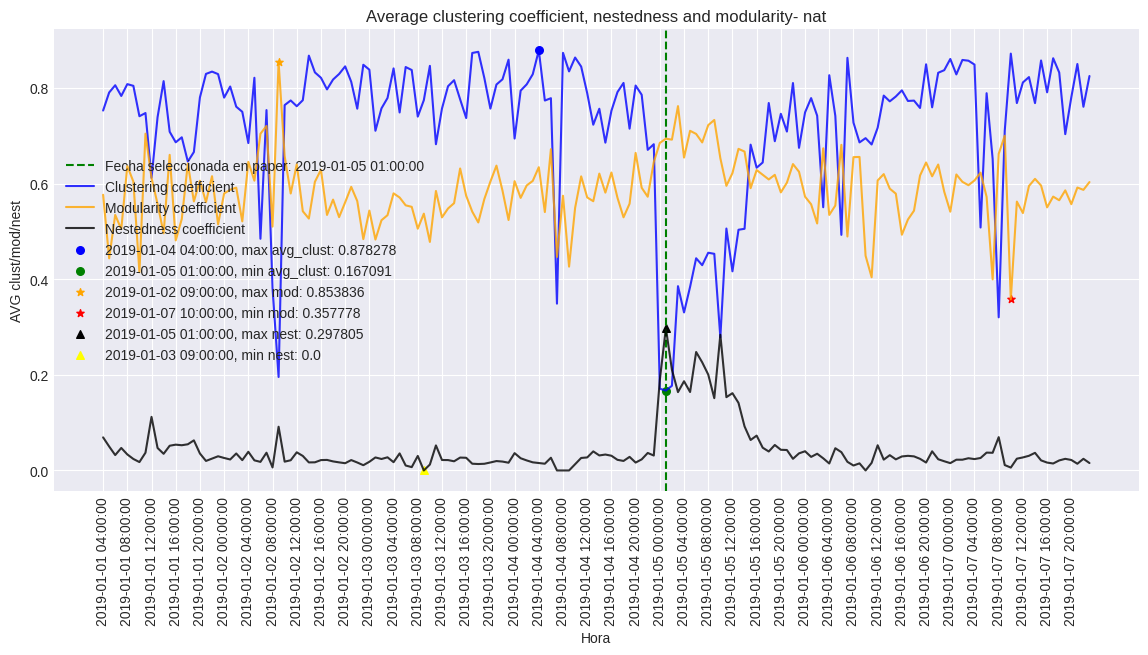

In [43]:
print(hour_sort)
if MANIFESTACION == "9n":
        fecha=str(int(437038))
        index_fecha=hour_sort.index(fecha)
        init=str(int(1573196400/3600))
        index_init=hour_sort.index(init)
        end=str(int(1573405200/3600))
        index_end=hour_sort.index(end)
else:
        fecha=str(int(429624))
        index_fecha=hour_sort.index(fecha)
        init=str(int(429531))
        index_init=hour_sort.index(init)
        end=str(int(1546902000/3600))
        index_end=hour_sort.index(end)
print("Fecha identificada en paper para", MANIFESTACION, datetime.datetime.fromtimestamp(int(fecha)*3600))
print("Fecha inicial en paper", dt_sort_arr[index_init], ", fecha final en paper", dt_sort_arr[index_end])
plt.figure(figsize=(14,6)) 
plt.style.use('seaborn-v0_8-darkgrid')    

plt.axvline(x=dt_sort_arr[index_fecha], color="green", ls="--", label="Fecha seleccionada en paper: " + str(datetime.datetime.fromtimestamp(int(fecha)*3600)))


plt.plot(dt_sort_arr[index_init:index_end], clust_sort[index_init:index_end], alpha=0.8, c="blue", label="Clustering coefficient")
plt.plot(dt_sort_arr[index_init:index_end], mod_sort[index_init:index_end], alpha=0.8, c="orange", label="Modularity coefficient")
plt.plot(dt_sort_arr[index_init:index_end], nest_sort[index_init:index_end], alpha=0.8, c="black", label="Nestedness coefficient")

name_max_clust = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))]) + ", max avg_clust: " + str(round(max(clust_sort[index_init:index_end]), 6))
name_min_clust  = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))]) + ", min avg_clust: " + str(round(min(clust_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))], max(clust_sort[index_init:index_end]), s=30, c="blue", marker="o", label = name_max_clust)
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))], min(clust_sort[index_init:index_end]), s=30, c="green", marker="o", label = name_min_clust)

name_max_mod = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))]) + ", max mod: " + str(round(max(mod_sort[index_init:index_end]), 6))
name_min_mod  = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))]) + ", min mod: " + str(round(min(mod_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))], max(mod_sort[index_init:index_end]), s=30, c="orange", marker="*", label = name_max_mod)
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))], min(mod_sort[index_init:index_end]), s=30, c="red", marker="*", label = name_min_mod)
#plt.plot(points[0], points[1], alpha=alpha, label="K_T = " + str(arr_kt_plot[index]))

name_max_nest = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))]) + ", max nest: " + str(round(max(nest_sort[index_init:index_end]), 6))
name_min_nest  = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))]) + ", min nest: " + str(round(min(nest_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))], max(nest_sort[index_init:index_end]), s=30, c="black", marker="^", label = name_max_nest)
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))], min(nest_sort[index_init:index_end]), s=30, c="yellow", marker="^", label = name_min_nest)
   
plt.xlabel("Hora")
plt.ylabel("AVG clust/mod/nest")
plt.xticks(dt_sort_arr[index_init:index_end][::4], labels=dt_sort_arr[index_init:index_end][::4])
plt.xticks(rotation=90)
plt.title("Average clustering coefficient, nestedness and modularity- " + MANIFESTACION)
plt.legend()

plt.savefig("paper_avg_clust_mod_nest_" + MANIFESTACION + file_maxcomp, bbox_inches = "tight")

plt.show()


In [44]:
dt_sort_arr[index_init]

datetime.datetime(2019, 1, 1, 4, 0)